In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stats
import pandas.plotting as pd_plot

import missingno as msno
import pandas_profiling

import re

import statsmodels.imputation.mice

from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing  import StandardScaler 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import scale
from sklearn.linear_model import LassoCV
import random

# Feature Selection/Dimension Reduction

In [2]:
OriginalDatasetwTypes = pd.read_csv("CleanedDataset.csv")
OriginalDataset = OriginalDatasetwTypes.copy().drop(["Unnamed: 0", "Sleeves", "P&P", "Frac Ports", \
                                      "Repeater Ports", "CT"], axis = 1)
DatasetDropna = pd.read_csv("NoNanDataset.csv")
DatasetMean = pd.read_csv("MeanImputationDS.csv")
DatasetII = pd.read_csv("IterativeImputeDS.csv")
imputer = KNNImputer(n_neighbors=10)
DatasetKNN = imputer.fit_transform(OriginalDataset.copy().select_dtypes([np.number]))
DatasetKNN = pd.DataFrame(DatasetKNN, columns = OriginalDataset.copy().select_dtypes([np.number]).columns)
from impyute.imputation import cs
np.random.seed(9)
data = OriginalDataset.copy().select_dtypes([np.number]).to_numpy()
DatasetMICE = cs.mice(data)
DatasetMICE = pd.DataFrame(DatasetMICE, columns = OriginalDataset.copy().select_dtypes([np.number]).columns)
DatasetIIandCI = pd.read_csv("DatasetIIandCI.csv")

## LASSO Regression

### Dataset with Dropped Data

Train score: 0.9784512121522406
Test score: 0.975443027672081
Number of coefficients used: 8
Root mean squared error: 7.811880511479986
[ 9.36313523e-05 -2.60011265e-04  1.35876702e-01  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  6.04279737e-07  9.26784833e-06
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.09074130e-01
  2.36956993e-01  0.00000000e+00  0.00000000e+00 -1.52634823e-03]


Unnamed: 0         9.363135e-05
Lateral Length    -2.600113e-04
Stages             1.358767e-01
Township           0.000000e+00
Range              0.000000e+00
Section           -0.000000e+00
Total Prop, lbs    6.042797e-07
Fluid, bbls        9.267848e-06
Best1 Mo BOPD      0.000000e+00
Best3 Mo BOPD      0.000000e+00
Best6 Mo BOPD      0.000000e+00
Best9 Mo BOPD      1.090741e-01
Best12 Mo BOPD     2.369570e-01
Latitude           0.000000e+00
Longitude          0.000000e+00
SPACING_CAPPED    -1.526348e-03
dtype: float64

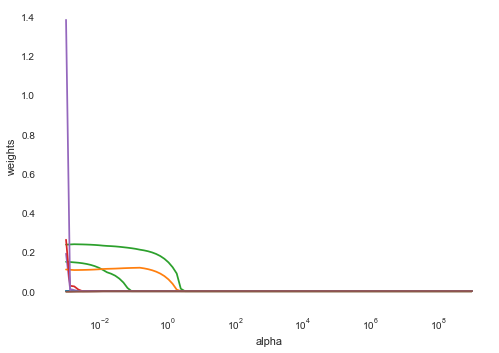

In [3]:
from math import sqrt
X = DatasetDropna.copy().select_dtypes([np.number]).drop(["12 month Cum Prod", "Year Drilled"], axis = 1)
scaler = StandardScaler()
sX = scaler.fit_transform(X)
y = DatasetDropna["12 month Cum Prod"]
sy = scaler.fit_transform(y.values.reshape((-1,1)))
alphas = 10**np.linspace(10,-2, 100)*0.05
coefs = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 1)
Lasso = linear_model.Lasso(max_iter = 300000, tol = 0.0001, normalize = True)
for a in alphas:
    Lasso.set_params(alpha = a)
    Lasso.fit(X_train, y_train)
    coefs.append(Lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale("log")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
    
Lassocv = LassoCV(alphas = None, cv = 20, max_iter = 300000, normalize = True)
Lassocv.fit(X_train, y_train)

Lasso.set_params(alpha = Lassocv.alpha_)
Lasso.fit(X_train, y_train)

y_pred = Lasso.predict(X_test)
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Train score:", Lasso.score(X_train, y_train))
print("Test score:", Lasso.score(X_test, y_test))
print("Number of coefficients used:", np.sum(Lasso.coef_!=0))
print("Root mean squared error:", rmse)
print(Lasso.coef_)
pd.Series(Lasso.coef_, index = X.columns)

#### Analysis

### Mean Imputation Dataset

Train score: 0.7683534108469994
Test score: 0.7732830711780654
Number of coefficients used: 12
Root mean squared error: 25.382535037817245
[-1.90109109e-04 -0.00000000e+00  2.02816125e-01 -3.54094422e-01
 -0.00000000e+00 -2.40605808e-02  3.40120892e-06  1.21503462e-04
  0.00000000e+00  5.46380372e-02  8.80929335e-02  3.38787309e-02
  9.50501458e-02 -0.00000000e+00  9.13785675e+00 -1.04454203e-02]


Unnamed: 0        -0.000190
Lateral Length    -0.000000
Stages             0.202816
Township          -0.354094
Range             -0.000000
Section           -0.024061
Total Prop, lbs    0.000003
Fluid, bbls        0.000122
Best1 Mo BOPD      0.000000
Best3 Mo BOPD      0.054638
Best6 Mo BOPD      0.088093
Best9 Mo BOPD      0.033879
Best12 Mo BOPD     0.095050
Latitude          -0.000000
Longitude          9.137857
SPACING_CAPPED    -0.010445
dtype: float64

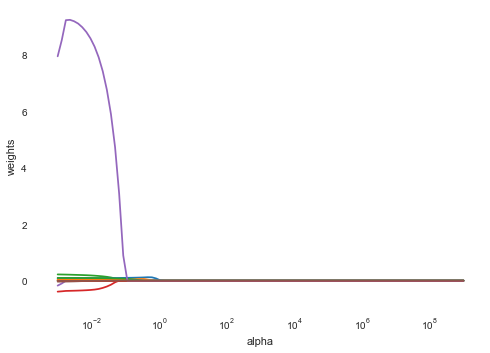

In [4]:
X = DatasetMean.copy().select_dtypes([np.number]).drop(["12 month Cum Prod", "Year Drilled"], axis = 1)
scaler = StandardScaler()
sX = scaler.fit_transform(X)
y = DatasetMean["12 month Cum Prod"]
sy = scaler.fit_transform(y.values.reshape((-1,1)))
alphas = 10**np.linspace(10,-2, 100)*0.05
coefs = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 1)
Lasso = linear_model.Lasso(max_iter = 300000, tol = 0.0001, normalize = True)
for a in alphas:
    Lasso.set_params(alpha = a)
    Lasso.fit(X_train, y_train)
    coefs.append(Lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale("log")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
    
Lassocv = LassoCV(alphas = None, cv = 20, max_iter = 300000, normalize = True)
Lassocv.fit(X_train, y_train)

Lasso.set_params(alpha = Lassocv.alpha_)
Lasso.fit(X_train, y_train)

y_pred = Lasso.predict(X_test)
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Train score:", Lasso.score(X_train, y_train))
print("Test score:", Lasso.score(X_test, y_test))
print("Number of coefficients used:", np.sum(Lasso.coef_!=0))
print("Root mean squared error:", rmse)
print(Lasso.coef_)
pd.Series(Lasso.coef_, index = X.columns)

#### Analysis

### Iterative Imputatoin Dataset

Train score: 0.9193368373475088
Test score: 0.9178193441295951
Number of coefficients used: 12
Root mean squared error: 15.281916448339881
[-9.92340905e-05 -5.01498226e-04  2.63129516e-01 -1.69817218e-01
 -0.00000000e+00 -2.64061920e-03  2.16054717e-06  7.45345406e-05
 -1.82133917e-03 -0.00000000e+00 -1.49770745e-01  0.00000000e+00
  5.63989993e-01 -0.00000000e+00  1.69708477e+00 -1.58709894e-02]


Unnamed: 0        -0.000099
Lateral Length    -0.000501
Stages             0.263130
Township          -0.169817
Range             -0.000000
Section           -0.002641
Total Prop, lbs    0.000002
Fluid, bbls        0.000075
Best1 Mo BOPD     -0.001821
Best3 Mo BOPD     -0.000000
Best6 Mo BOPD     -0.149771
Best9 Mo BOPD      0.000000
Best12 Mo BOPD     0.563990
Latitude          -0.000000
Longitude          1.697085
SPACING_CAPPED    -0.015871
dtype: float64

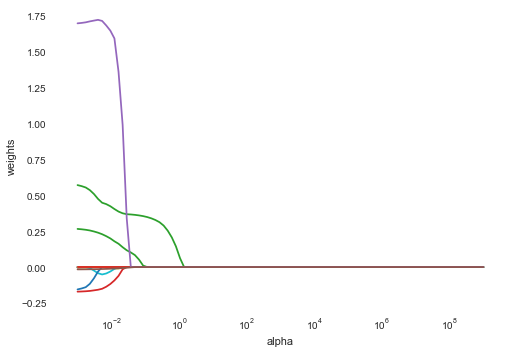

In [5]:
X = DatasetII.copy().select_dtypes([np.number]).drop(["12 month Cum Prod", "Year Drilled"], axis = 1)
scaler = StandardScaler()
sX = scaler.fit_transform(X)
y = DatasetII["12 month Cum Prod"]
sy = scaler.fit_transform(y.values.reshape((-1,1)))
alphas = 10**np.linspace(10,-2, 100)*0.05
coefs = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 1)
Lasso = linear_model.Lasso(max_iter = 300000, tol = 0.0001, normalize = True)
for a in alphas:
    Lasso.set_params(alpha = a)
    Lasso.fit(X_train, y_train)
    coefs.append(Lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale("log")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
    
Lassocv = LassoCV(alphas = None, cv = 20, max_iter = 300000, normalize = True)
Lassocv.fit(X_train, y_train)

Lasso.set_params(alpha = Lassocv.alpha_)
Lasso.fit(X_train, y_train)

y_pred = Lasso.predict(X_test)
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Train score:", Lasso.score(X_train, y_train))
print("Test score:", Lasso.score(X_test, y_test))
print("Number of coefficients used:", np.sum(Lasso.coef_!=0))
print("Root mean squared error:", rmse)
print(Lasso.coef_)
pd.Series(Lasso.coef_, index = X.columns)

#### Analysis

### K- NN Imputation Dataset

Train score: 0.7652285908428245
Test score: 0.7660899276286498
Number of coefficients used: 13
Root mean squared error: 25.78205206413322
[ 3.22046235e-04  3.66362212e-01 -2.73303591e-01 -0.00000000e+00
 -4.22946093e-02 -3.41260664e-06  1.18271029e-04  1.54890947e-03
  3.92475004e-02  1.20310563e-01  6.23826759e-02  5.21283508e-02
 -0.00000000e+00  6.99645423e+00  2.06923058e-03]


Lateral Length     0.000322
Stages             0.366362
Township          -0.273304
Range             -0.000000
Section           -0.042295
Total Prop, lbs   -0.000003
Fluid, bbls        0.000118
Best1 Mo BOPD      0.001549
Best3 Mo BOPD      0.039248
Best6 Mo BOPD      0.120311
Best9 Mo BOPD      0.062383
Best12 Mo BOPD     0.052128
Latitude          -0.000000
Longitude          6.996454
SPACING_CAPPED     0.002069
dtype: float64

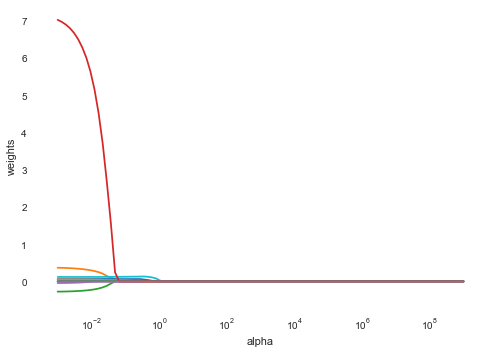

In [6]:
X = DatasetKNN.copy().select_dtypes([np.number]).drop(["12 month Cum Prod", "Year Drilled"], axis = 1)
scaler = StandardScaler()
sX = scaler.fit_transform(X)
y = DatasetKNN["12 month Cum Prod"]
sy = scaler.fit_transform(y.values.reshape((-1,1)))
alphas = 10**np.linspace(10,-2, 100)*0.05
coefs = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 1)
Lasso = linear_model.Lasso(max_iter = 300000, tol = 0.0001, normalize = True)
for a in alphas:
    Lasso.set_params(alpha = a)
    Lasso.fit(X_train, y_train)
    coefs.append(Lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale("log")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
    
Lassocv = LassoCV(alphas = None, cv = 20, max_iter = 300000, normalize = True)
Lassocv.fit(X_train, y_train)

Lasso.set_params(alpha = Lassocv.alpha_)
Lasso.fit(X_train, y_train)

y_pred = Lasso.predict(X_test)
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Train score:", Lasso.score(X_train, y_train))
print("Test score:", Lasso.score(X_test, y_test))
print("Number of coefficients used:", np.sum(Lasso.coef_!=0))
print("Root mean squared error:", rmse)
print(Lasso.coef_)
pd.Series(Lasso.coef_, index = X.columns)

#### Analysis

### MICE Imputation Dataset

Train score: 0.919159648628821
Test score: 0.9188427159690814
Number of coefficients used: 11
Root mean squared error: 15.1864677351114
[-4.64578771e-04  2.30263448e-01 -1.52098368e-01 -0.00000000e+00
 -0.00000000e+00  2.44671188e-06  7.13116893e-05  3.26710655e-02
 -4.42567803e-02 -1.82076693e-01  0.00000000e+00  6.08431341e-01
 -0.00000000e+00  1.73975868e+00 -1.52858872e-02]


Lateral Length    -0.000465
Stages             0.230263
Township          -0.152098
Range             -0.000000
Section           -0.000000
Total Prop, lbs    0.000002
Fluid, bbls        0.000071
Best1 Mo BOPD      0.032671
Best3 Mo BOPD     -0.044257
Best6 Mo BOPD     -0.182077
Best9 Mo BOPD      0.000000
Best12 Mo BOPD     0.608431
Latitude          -0.000000
Longitude          1.739759
SPACING_CAPPED    -0.015286
dtype: float64

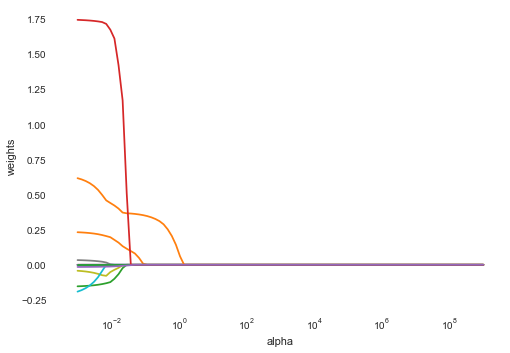

In [7]:
X = DatasetMICE.copy().select_dtypes([np.number]).drop(["12 month Cum Prod", "Year Drilled"], axis = 1)
scaler = StandardScaler()
sX = scaler.fit_transform(X)
y = DatasetMICE["12 month Cum Prod"]
sy = scaler.fit_transform(y.values.reshape((-1,1)))
alphas = 10**np.linspace(10,-2, 100)*0.05
coefs = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 1)
Lasso = linear_model.Lasso(max_iter = 300000, tol = 0.0001, normalize = True)
for a in alphas:
    Lasso.set_params(alpha = a)
    Lasso.fit(X_train, y_train)
    coefs.append(Lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale("log")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
    
Lassocv = LassoCV(alphas = None, cv = 20, max_iter = 300000, normalize = True)
Lassocv.fit(X_train, y_train)

Lasso.set_params(alpha = Lassocv.alpha_)
Lasso.fit(X_train, y_train)

y_pred = Lasso.predict(X_test)
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Train score:", Lasso.score(X_train, y_train))
print("Test score:", Lasso.score(X_test, y_test))
print("Number of coefficients used:", np.sum(Lasso.coef_!=0))
print("Root mean squared error:", rmse)
print(Lasso.coef_)
pd.Series(Lasso.coef_, index = X.columns)

#### Analysis

### Seperating by Completion Type

In [8]:

Category = "Completion Type"
DatasetII[Category] = OriginalDatasetwTypes[Category]
DatasetII["Sleeves"] = OriginalDatasetwTypes["Sleeves"]
DatasetII["P&P"] = OriginalDatasetwTypes["P&P"]
DatasetII["Frac Ports"] = OriginalDatasetwTypes["Frac Ports"]
DatasetII["Repeater Ports"] = OriginalDatasetwTypes["Repeater Ports"]
DatasetII["CT"] = OriginalDatasetwTypes["CT"]
DatasetII = DatasetII.dropna(axis=0, subset=['Completion Type'])

DatasetIISleeves = pd.concat([\
                               DatasetII[DatasetII[Category] == \
                                          "Sleeves"], \
                               DatasetII[DatasetII[Category] == \
                                           "Sleeves and P & P"]])
DatasetIISleeves = DatasetIISleeves.fillna(0)

DatasetIIPandP = pd.concat([\
                            DatasetII[DatasetII[Category] == \
                                      "P & P"], \
                            DatasetII[DatasetII[Category] == \
                                      "Sleeves and P & P"], \
                            DatasetII[DatasetII[Category] == \
                                      "Frac Ports and P & P"], \
                            DatasetII[DatasetII[Category] == \
                                       "P & P and CT"], \
                            DatasetII[DatasetII[Category] == \
                                      "Repeater Ports and P & P"]])
DatasetIIPandP = DatasetIIPandP.fillna(0)

DatasetIIFracPorts = pd.concat([\
                                DatasetII[DatasetII[Category] == \
                                         "Frac Ports"], \
                                DatasetII[DatasetII[Category] == \
                                         "Frac Ports and P & P"], \
                                DatasetII[DatasetII[Category] == \
                                         "Frac Ports and Repeater Ports"]])
DatasetIIFracPorts = DatasetIIFracPorts.fillna(0)

DatasetIIRepeaterPorts = pd.concat([\
                                    DatasetII[DatasetII[Category] == \
                                        "Frac Ports and Repeater Ports"],
                                    DatasetII[DatasetII[Category] == \
                                              "Repeater Ports and P & P"]])
DatasetIIRepeaterPorts = DatasetIIRepeaterPorts.fillna(0)

DatasetIICT = pd.concat([\
                         DatasetII[DatasetII[Category] == \
                                   "CT"], \
                         DatasetII[DatasetII[Category] == \
                                   "P & P and CT"]])
DatasetIICT = DatasetIICT.fillna(0)
DatasetIIOH = DatasetII[DatasetII[Category] == "OH"]
DatasetIIOH = DatasetIIOH.fillna(0)

DatasetIIScreen = DatasetII[DatasetII[Category] == "Screen"]
DatasetIIScreen = DatasetIIScreen.fillna(0)

DatasetIICementedL = DatasetII[DatasetII[Category] == "Cemented Liner"]
DatasetIICementedL = DatasetIICementedL.fillna(0)

DatasetIIPerforatedL = DatasetII[DatasetII[Category] == \
                                   "Perforated Liner"]
DatasetIIPerforatedL = DatasetIIPerforatedL.fillna(0)

DatasetIIother = pd.concat([DatasetIIOH, DatasetIIScreen, \
                           DatasetIICementedL, DatasetIIPerforatedL, DatasetIIFracPorts, DatasetIIRepeaterPorts])


### Sleeves

Train score: 0.9227018783782674
Test score: 0.9318787834980496
Number of coefficients used: 14
Root mean squared error: 12.159003281165456
[-6.01579778e-04  2.92234357e-01 -2.33246343e-01 -0.00000000e+00
 -2.27509030e-02  3.52410448e-06 -8.67943583e-06  4.52463622e-04
  1.76508375e-02 -9.65952755e-02 -0.00000000e+00  4.69638386e-01
 -0.00000000e+00  1.12472392e+00 -8.98397439e-03  1.29798992e-02
 -1.12132911e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]


Lateral Length    -0.000602
Stages             0.292234
Township          -0.233246
Range             -0.000000
Section           -0.022751
Total Prop, lbs    0.000004
Fluid, bbls       -0.000009
Best1 Mo BOPD      0.000452
Best3 Mo BOPD      0.017651
Best6 Mo BOPD     -0.096595
Best9 Mo BOPD     -0.000000
Best12 Mo BOPD     0.469638
Latitude          -0.000000
Longitude          1.124724
SPACING_CAPPED    -0.008984
Sleeves            0.012980
P&P               -0.112133
Frac Ports         0.000000
Repeater Ports     0.000000
CT                 0.000000
dtype: float64

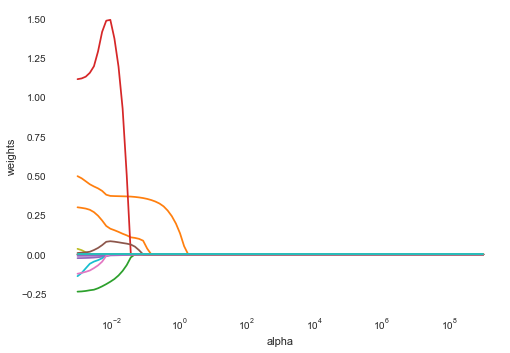

In [9]:
X = DatasetIISleeves.copy().select_dtypes([np.number]).drop(["12 month Cum Prod", "Year Drilled", "Unnamed: 0"], axis = 1)
scaler = StandardScaler()
sX = scaler.fit_transform(X)
y = DatasetIISleeves["12 month Cum Prod"]
sy = scaler.fit_transform(y.values.reshape((-1,1)))
alphas = 10**np.linspace(10,-2, 100)*0.05
coefs = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 1)
Lasso = linear_model.Lasso(max_iter = 300000, tol = 0.0001, normalize = True)
for a in alphas:
    Lasso.set_params(alpha = a)
    Lasso.fit(X_train, y_train)
    coefs.append(Lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale("log")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
    
Lassocv = LassoCV(alphas = None, cv = 20, max_iter = 300000, normalize = True)
Lassocv.fit(X_train, y_train)

Lasso.set_params(alpha = Lassocv.alpha_)
Lasso.fit(X_train, y_train)

y_pred = Lasso.predict(X_test)
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Train score:", Lasso.score(X_train, y_train))
print("Test score:", Lasso.score(X_test, y_test))
print("Number of coefficients used:", np.sum(Lasso.coef_!=0))
print("Root mean squared error:", rmse)
print(Lasso.coef_)
pd.Series(Lasso.coef_, index = X.columns)

#### Analysis

### P & P

Train score: 0.9125551725854727
Test score: 0.9105132713262579
Number of coefficients used: 14
Root mean squared error: 17.891623785825605
[-3.96501919e-04  1.66133851e-01 -2.90090980e-01 -0.00000000e+00
  4.43652486e-02  2.29731085e-06  8.04214463e-05 -3.34969436e-03
 -1.45171907e-02 -1.90360074e-01  0.00000000e+00  6.43827758e-01
 -0.00000000e+00  1.78774866e+00 -2.20032296e-02  1.38641192e-02
  0.00000000e+00  0.00000000e+00 -4.95397544e-01  0.00000000e+00]


Lateral Length    -0.000397
Stages             0.166134
Township          -0.290091
Range             -0.000000
Section            0.044365
Total Prop, lbs    0.000002
Fluid, bbls        0.000080
Best1 Mo BOPD     -0.003350
Best3 Mo BOPD     -0.014517
Best6 Mo BOPD     -0.190360
Best9 Mo BOPD      0.000000
Best12 Mo BOPD     0.643828
Latitude          -0.000000
Longitude          1.787749
SPACING_CAPPED    -0.022003
Sleeves            0.013864
P&P                0.000000
Frac Ports         0.000000
Repeater Ports    -0.495398
CT                 0.000000
dtype: float64

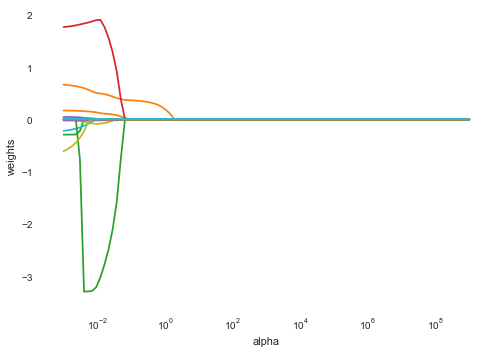

In [10]:
X = DatasetIIPandP.copy().select_dtypes([np.number]).drop(["12 month Cum Prod", "Year Drilled", "Unnamed: 0"], axis = 1)
scaler = StandardScaler()
sX = scaler.fit_transform(X)
y = DatasetIIPandP["12 month Cum Prod"]
sy = scaler.fit_transform(y.values.reshape((-1,1)))
alphas = 10**np.linspace(10,-2, 100)*0.05
coefs = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 1)
Lasso = linear_model.Lasso(max_iter = 300000, tol = 0.0001, normalize = True)
for a in alphas:
    Lasso.set_params(alpha = a)
    Lasso.fit(X_train, y_train)
    coefs.append(Lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale("log")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
    
Lassocv = LassoCV(alphas = None, cv = 20, max_iter = 300000, normalize = True)
Lassocv.fit(X_train, y_train)

Lasso.set_params(alpha = Lassocv.alpha_)
Lasso.fit(X_train, y_train)

y_pred = Lasso.predict(X_test)
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Train score:", Lasso.score(X_train, y_train))
print("Test score:", Lasso.score(X_test, y_test))
print("Number of coefficients used:", np.sum(Lasso.coef_!=0))
print("Root mean squared error:", rmse)
print(Lasso.coef_)
pd.Series(Lasso.coef_, index = X.columns)

#### Analysis

### Other

Train score: 0.9707992200442952
Test score: 0.9833797406488702
Number of coefficients used: 12
Root mean squared error: 4.8063487318190825
[-3.99867575e-04  3.24942393e-02  1.24831684e-02  0.00000000e+00
 -3.78034705e-02  2.04921063e-07 -0.00000000e+00  2.03161212e-03
  0.00000000e+00  0.00000000e+00  1.82445574e-01  1.50564818e-01
  0.00000000e+00 -1.29433249e+00  6.02811586e-03  0.00000000e+00
 -3.57072794e-02 -6.25351146e-03 -0.00000000e+00  0.00000000e+00]


Lateral Length    -3.998676e-04
Stages             3.249424e-02
Township           1.248317e-02
Range              0.000000e+00
Section           -3.780347e-02
Total Prop, lbs    2.049211e-07
Fluid, bbls       -0.000000e+00
Best1 Mo BOPD      2.031612e-03
Best3 Mo BOPD      0.000000e+00
Best6 Mo BOPD      0.000000e+00
Best9 Mo BOPD      1.824456e-01
Best12 Mo BOPD     1.505648e-01
Latitude           0.000000e+00
Longitude         -1.294332e+00
SPACING_CAPPED     6.028116e-03
Sleeves            0.000000e+00
P&P               -3.570728e-02
Frac Ports        -6.253511e-03
Repeater Ports    -0.000000e+00
CT                 0.000000e+00
dtype: float64

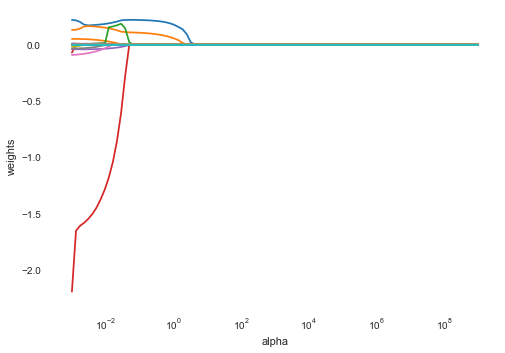

In [11]:
X = DatasetIIother.copy().select_dtypes([np.number]).drop(["12 month Cum Prod", "Year Drilled", "Unnamed: 0"], axis = 1)
scaler = StandardScaler()
sX = scaler.fit_transform(X)
y = DatasetIIother["12 month Cum Prod"]
sy = scaler.fit_transform(y.values.reshape((-1,1)))
alphas = 10**np.linspace(10,-2, 100)*0.05
coefs = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4, random_state = 1)
Lasso = linear_model.Lasso(max_iter = 300000, tol = 0.0001, normalize = True)
for a in alphas:
    Lasso.set_params(alpha = a)
    Lasso.fit(X_train, y_train)
    coefs.append(Lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale("log")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
    
Lassocv = LassoCV(alphas = None, cv = 20, max_iter = 300000, normalize = True)
Lassocv.fit(X_train, y_train)

Lasso.set_params(alpha = Lassocv.alpha_)
Lasso.fit(X_train, y_train)

y_pred = Lasso.predict(X_test)
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Train score:", Lasso.score(X_train, y_train))
print("Test score:", Lasso.score(X_test, y_test))
print("Number of coefficients used:", np.sum(Lasso.coef_!=0))
print("Root mean squared error:", rmse)
print(Lasso.coef_)
pd.Series(Lasso.coef_, index = X.columns)

#### Analysis

In [44]:
features = DatasetIIandCI.copy()
features = pd.get_dummies(features)
labels = np.array(features["12 month Cum Prod"])
features = features.drop(columns = ["12 month Cum Prod"])
feature_list = list(features.columns)
features = np.array(features)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 23)
baseline_preds = test_features[:, feature_list.index("Best12 Mo BOPD")]
baseline_errors = abs(baseline_preds - test_labels)
print("Average baseline error: ", round(np.mean(baseline_errors), 2))



Average baseline error:  151.79


In [45]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, random_state = 23)
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=23, verbose=0, warm_start=False)

In [46]:
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)
print("Mean Absolute Error:", round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 5.07 degrees.


In [47]:
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print("Accuracy:", round(accuracy, 2), "%.")

Accuracy: 93.51 %.


In [50]:
from sklearn.tree import export_graphviz
import pydot
tree = rf.estimators_[5]
export_graphviz(tree, out_file = "tree.dot",
               feature_names = feature_list, rounded = True,
               precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

In [51]:
rf_small = RandomForestRegressor(n_estimators = 10,
                                max_depth = 3)
rf_small.fit(train_features, train_labels)
tree_small = rf_small.estimators_[5]
export_graphviz(tree_small, out_file = 'small_tree.dot',
               feature_names = feature_list,
               rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png')

In [52]:
importances = list(rf.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Best12 Mo BOPD       Importance: 0.86
Variable: Best9 Mo BOPD        Importance: 0.05
Variable: Year Drilled         Importance: 0.05
Variable: Best6 Mo BOPD        Importance: 0.01
Variable: Unnamed: 0           Importance: 0.0
Variable: Lateral Length       Importance: 0.0
Variable: Stages               Importance: 0.0
Variable: Township             Importance: 0.0
Variable: Range                Importance: 0.0
Variable: Section              Importance: 0.0
Variable: Total Prop, lbs      Importance: 0.0
Variable: Fluid, bbls          Importance: 0.0
Variable: Best1 Mo BOPD        Importance: 0.0
Variable: Best3 Mo BOPD        Importance: 0.0
Variable: Latitude             Importance: 0.0
Variable: Longitude            Importance: 0.0
Variable: SPACING_CAPPED       Importance: 0.0
Variable: Operator_Operator 1  Importance: 0.0
Variable: Operator_Operator 10 Importance: 0.0
Variable: Operator_Operator 11 Importance: 0.0
Variable: Operator_Operator 12 Importance: 0.0
Variable:

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]